<a href="https://colab.research.google.com/github/nickwan/pokemon_matchup/blob/master/pokemon_matchup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokemon matchup model 
Given two trainers with full sets of Pokemon, which trainer would win?  

In [1]:
!pip install adjustText --quiet
!pip install shap --quiet

In [2]:
import time
from joblib import dump, load
import random
import requests
import json
import datetime
import os
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from adjustText import adjust_text
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, f1_score, auc, roc_curve
from sklearn.model_selection import KFold 

from scipy.stats import pearsonr
import shap
shap.initjs()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
project_dir = '/content/drive/My Drive/pokemon-battles'
combats = pd.read_csv(f"{project_dir}/data/combats.csv")
pokemon = pd.read_csv(f"{project_dir}/data/pokemon.csv")
tests = pd.read_csv(f"{project_dir}/data/tests.csv")

# modeling notes  
let's train initially on `'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'` and then throw in `'Type 1', 'Type 2'` after the initial train and lastly `'Generation', 'Legendary'`. 

unsure if i should go the feature engineering route first or if i should just create the match up model directly. I suppose the match up model directly would be fun but more abstract of an explaination as opposed to creating a single statistic similar to ELO rating for each pokemon and then simply creating a linear model for win probability.  

# this is the data munge

In [4]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [5]:
id = ['#', 'Name']
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
_df = pokemon.loc[:,id+features].add_suffix('_1').rename(columns={'#_1':'First_pokemon'})
model_data = combats.merge(_df)

_df = pokemon.loc[:,id+features].add_suffix('_2').rename(columns={'#_2':'Second_pokemon'})
model_data = model_data.merge(_df)

model_data.loc[model_data['First_pokemon'] == model_data['Winner'], 'winner_first'] = 1
model_data['winner_first'] = model_data['winner_first'].fillna(0).astype(int) 
model_data.shape

(50000, 18)

# Data Descriptions 

In [35]:
def xy_plt(x, y, data):
  sns.regplot(x, y,data=data)
  plt.title(f"{x} x {y}")
  sns.despine()
  plt.show()

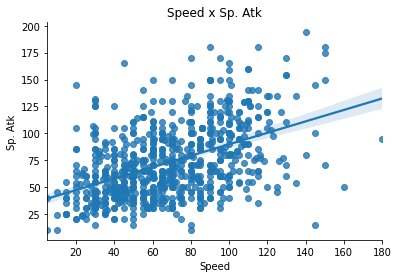

In [38]:
x = 'Speed'
y = 'Sp. Atk'
xy_plt(x,y,pokemon)

# linear model 1

In [6]:
target = 'winner_first'
model_feats = [x for x in model_data.columns.values if x not in ['First_pokemon', 'Second_pokemon', 'Winner', 'Name_1', 'Name_2', target]]

In [7]:
df_pred = pd.DataFrame()
kf = KFold(10, shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = LogisticRegression(penalty='none')
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])  
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

(50000, 19)

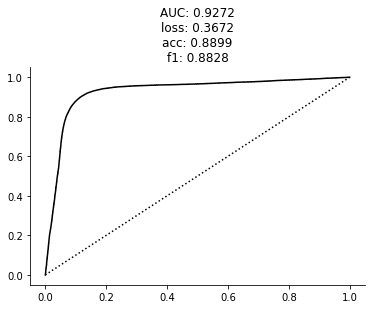

In [8]:
fp, tp, thresh = roc_curve(df_pred[target], df_pred[f"{target}_pred"])
roc_auc = auc(fp, tp)
loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))
f1 = f1_score(df_pred[target], df_pred[f"{target}_pred"].round(0))
print(f"""""")
plt.plot(fp,tp,'k-')
plt.plot([0,1],[0,1],'k:')
plt.title(f"""AUC: {round(roc_auc,4)}\nloss: {round(loss,4)}\nacc: {round(acc,4)}\nf1: {round(f1,4)}""")
sns.despine()
plt.show()

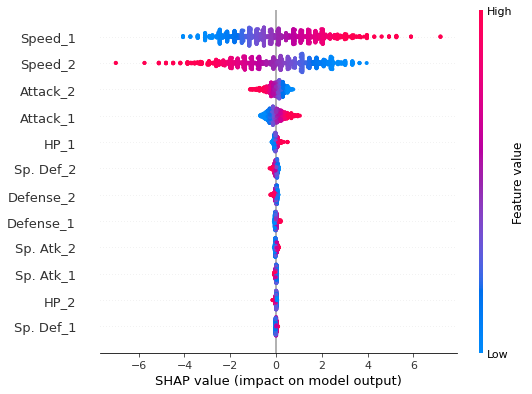

In [9]:
test_data = model_data.loc[:,model_feats].sample(1500)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats]
shap_data = test_data.loc[:,model_feats]
explainer = shap.LinearExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

This was pretty good, but let's just try a RF to see if simply moving from a linear model to a non-linear model helps at all 

# RF model 1

In [23]:
model_data.sample(3)

,First_pokemon,Second_pokemon,Winner,Name_1,HP_1,Attack_1,Defense_1,Sp. Atk_1,Sp. Def_1,Speed_1,Name_2,HP_2,Attack_2,Defense_2,Sp. Atk_2,Sp. Def_2,Speed_2,winner_first
31722,160,108,108,Dratini,41,64,45,50,50,50,Kingler,55,130,115,50,50,75,0
2053,612,165,165,Sandile,50,72,35,35,35,65,Mega Mewtwo Y,106,150,70,194,120,140,0
46323,202,204,204,Politoed,90,75,75,90,100,70,Skiploom,55,45,50,45,65,80,0


In [10]:
target = 'winner_first'
model_feats = [x for x in model_data.columns.values if x not in ['First_pokemon', 'Second_pokemon', 'Winner', 'Name_1', 'Name_2', target]]

In [11]:
df_pred = pd.DataFrame()
kf = KFold(10, shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = RandomForestClassifier()
  model.fit(train_data.loc[:,model_feats], train_data.loc[:,target])  
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape  


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

(50000, 19)

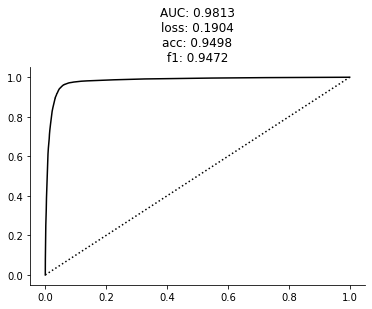

In [12]:
fp, tp, thresh = roc_curve(df_pred[target], df_pred[f"{target}_pred"])
roc_auc = auc(fp, tp)
loss = log_loss(df_pred[target], df_pred[f"{target}_pred"])
acc = accuracy_score(df_pred[target], df_pred[f"{target}_pred"].round(0))
f1 = f1_score(df_pred[target], df_pred[f"{target}_pred"].round(0))
print(f"""""")
plt.plot(fp,tp,'k-')
plt.plot([0,1],[0,1],'k:')
plt.title(f"""AUC: {round(roc_auc,4)}\nloss: {round(loss,4)}\nacc: {round(acc,4)}\nf1: {round(f1,4)}""")
sns.despine()
plt.show()

In [19]:
test_data = model_data.loc[:,model_feats].sample(1000)
train_data = model_data.loc[~model_data.index.isin(test_data.index.values), model_feats].sample(200)
shap_data = test_data.loc[:,model_feats]
explainer = shap.TreeExplainer(model, train_data.loc[:,model_feats]) 
shap_values = explainer.shap_values(shap_data)

100%|===================| 1999/2000 [05:27<00:00]       

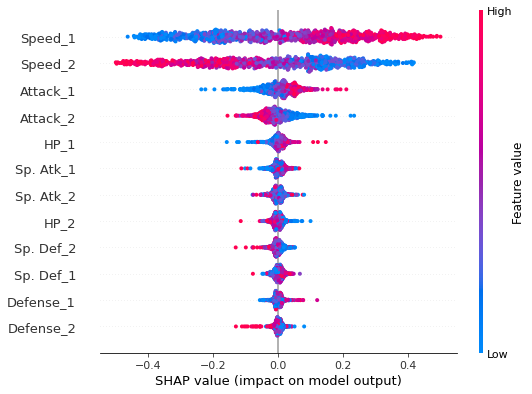

In [20]:
shap.summary_plot(shap_values[1], shap_data)

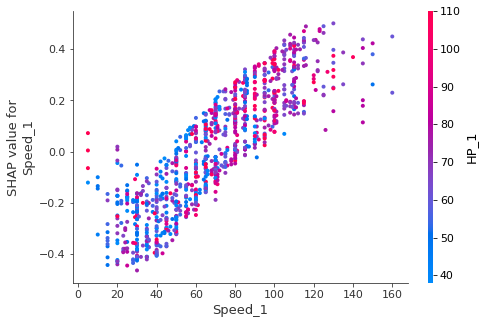

In [31]:
shap.dependence_plot("Speed_1", shap_values[1], shap_data, interaction_index="HP_1")

In [64]:
def matchup_prob(poke1, poke2, model, verbose=True):
  id = ['#', 'Name']
  features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
  _df = pd.DataFrame([[poke1,poke2]], columns=['First_pokemon', 'Second_pokemon'])
  _df2 = pokemon.loc[:,id+features].add_suffix('_1').rename(columns={'#_1':'First_pokemon'})
  model_data = _df.merge(_df2)

  _df = pokemon.loc[:,id+features].add_suffix('_2').rename(columns={'#_2':'Second_pokemon'})
  model_data = model_data.merge(_df)
  win_prob = pd.DataFrame(model.predict_proba(model_data.loc[:,model_feats]))[1].values[0]
  if verbose: 
    poke1_name = pokemon.loc[pokemon['#'] == poke1,'Name'].values[0]
    poke2_name = pokemon.loc[pokemon['#'] == poke2,'Name'].values[0]
    if win_prob >0.5:
      winner_name = poke1_name 
      win_pct = win_prob*100
    else:
      winner_name = poke2_name 
      win_pct = (1-win_prob)*100
    print(f"""Pokemon 1: {poke1_name}\nPokemon 2: {poke2_name} \n{winner_name} WINS! (win prob: {round(win_pct,0)})""")
  return win_prob

In [68]:
pokemon.loc[pokemon['Name']=='Magikarp']

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
139,140,Magikarp,Water,NaN,20,10,55,15,20,80,1,False


In [73]:
poke1 = 140
poke2 = 15
matchup_prob(poke1, poke2, model, verbose=True)

Pokemon 1: Magikarp
Pokemon 2: Metapod 
Metapod WINS! (win prob: 54.0)


0.46